# Create Cached Embeddings (DuckDB) from Long-Format Parquets

This notebook is a runnable, **manual step-by-step** workflow from **long-format** parquet extractions → **wide** time-series parquets → **merged** wide parquet → **DuckDB embeddings cache** populated with Presto embeddings.

Later in the notebook there is also a **script alternative** (`scripts/misc/build_embeddings_cache.py`) that performs the same pipeline end-to-end.

## Notebook flow

This notebook is organized as:

1) **Set parameters** (paths + parameters)
2) **Discover** long-format parquet files
3) **Inspect** a sample long parquet (schema + a small preview)
4) **Convert** long → wide with `worldcereal.utils.timeseries.process_parquet`
5) **Merge** wide parquets into one parquet (Arrow streaming, memory-safe)
6) **Compute** and store embeddings into a DuckDB cache via `worldcereal.train.embeddings_cache.compute_embeddings`
7) **Alternative**: run the pipeline script (optional)
8) **Explore** the DuckDB cache (stats + sampling + PCA plot)

Notes:
- DuckDB may throw a lock error if the same DB is open for writing in another process/kernel. Use a different DB path or close other connections.

In [1]:
from __future__ import annotations

from pathlib import Path

# -----------------------------
# User parameters (edit these)
# -----------------------------
user_home = Path("/home/vito/shahs")
# Optional: script alternative (used later in the notebook)
SCRIPT = user_home / "TestFolder/worldcereal-classification/scripts/misc/build_embeddings_cache.py"

# Long-format parquet input: can be a directory OR a single `.parquet` file
INPUT_LONG_DIR = user_home / "projects/worldcereal/data/worldcereal_all_extractions.parquet"
PARQUET_GLOB = "**/*.parquet"

# Wide parquet outputs (one per long parquet)
WIDE_DIR = user_home / "projects/worldcereal/data/cached_wide_merged2/cached_wide_parquets"
WIDE_SUFFIX = "_ppq"
OVERWRITE_WIDE = False

# Merged wide parquet output (single file)
MERGED_WIDE_PATH = user_home / "projects/worldcereal/data/cached_wide_merged2/worldcereal_all_extractions_wide_month2.parquet"
OVERWRITE_MERGED = False

# DuckDB embeddings cache output
EMBEDDINGS_DB_PATH = user_home / "projects/worldcereal/data/cached_embeddings/embeddings_cache_LANDCOVER10_updated2.duckdb"

# Presto checkpoint (URL or local path)
PRESTO_URL = (
    "https://artifactory.vgt.vito.be/artifactory/auxdata-public/worldcereal/models/"
    "PhaseII/presto-ss-wc_longparquet_random-window-cut_no-time-token_epoch96.pt"
 )

# --------------
# Manual pipeline knobs
# --------------

# (A) long -> wide
FREQ = "month"  # 'month' or 'dekad'
REQUIRED_MIN_TIMESTEPS = None  # int | None
USE_VALID_TIME = True
MIN_EDGE_BUFFER = 1
MAX_TIMESTEPS_TRIM = 18  # int | 'auto' | None
WIDE_ENGINE = "pyarrow"  # 'pyarrow' or 'fastparquet'
WIDE_COMPRESSION = "snappy"

# Limit long files for quick iteration (set to None for all)
MAX_LONG_FILES = None  # e.g. 5

# (B) merge wide parquets
MERGE_BATCH_ROWS = 100_000
MERGE_ROW_GROUP_SIZE = 100_000
MERGE_COMPRESSION = "zstd"

# (C) embeddings cache population
BATCH_SIZE = 16_384
NUM_WORKERS = 2
PARQUET_BATCH_ROWS = 200_000
FORCE_RECOMPUTE = False
PREMATCH = True  # skip fully-cached parquet batches (for this model_hash)

assert INPUT_LONG_DIR.exists(), INPUT_LONG_DIR
print("Input:", INPUT_LONG_DIR)
print("Wide dir:", WIDE_DIR)
print("Merged wide:", MERGED_WIDE_PATH)
print("DB:", EMBEDDINGS_DB_PATH)

Input: /home/vito/shahs/projects/worldcereal/data/worldcereal_all_extractions.parquet
Wide dir: /home/vito/shahs/projects/worldcereal/data/cached_wide_merged2/cached_wide_parquets
Merged wide: /home/vito/shahs/projects/worldcereal/data/cached_wide_merged2/worldcereal_all_extractions_wide_month2.parquet
DB: /home/vito/shahs/projects/worldcereal/data/cached_embeddings/embeddings_cache_LANDCOVER10_updated2.duckdb


### 3) Convert long → wide via `process_parquet`

This writes one wide parquet per long parquet into `WIDE_DIR`.

In [2]:
import gc
from pathlib import Path

import pandas as pd
from tqdm.auto import tqdm

from worldcereal.utils.timeseries import process_parquet

def wide_out_path(wide_dir: Path, raw_path: Path, suffix: str = "_ppq") -> Path:
    return wide_dir / f"{raw_path.stem}{suffix}.parquet"

WIDE_DIR.mkdir(parents=True, exist_ok=True)
already_processed = 0
wide_files: list[Path] = []
empty_long: list[Path] = []
errored_long: list[Path] = []
raw_files = sorted(INPUT_LONG_DIR.glob(PARQUET_GLOB))
for pf in tqdm(raw_files, desc="process_parquet", unit="file"):
    out_path = wide_out_path(WIDE_DIR, pf, suffix=WIDE_SUFFIX)
    if out_path.exists() and not OVERWRITE_WIDE:
        already_processed += 1
        wide_files.append(out_path)
        continue
    try:
        df_long = pd.read_parquet(pf)
        # check if sample_id is stored in the index in some upstream outputs
        if "sample_id" not in df_long.columns and "sample_id" in df_long.index.names:
            print("Resetting index to get sample_id column")
            df_long.reset_index(drop=True, inplace=True)
        df_wide = process_parquet(
            df_long,
            freq=FREQ,
            required_min_timesteps=REQUIRED_MIN_TIMESTEPS,
            use_valid_time=USE_VALID_TIME,
            min_edge_buffer=MIN_EDGE_BUFFER,
            max_timesteps_trim=MAX_TIMESTEPS_TRIM,
        )
    except Exception as e:
        print(f"ERROR processing {pf}: {type(e).__name__}: {e}")
        errored_long.append(pf)
        # don't continue , raise hell
        raise e
        # raise e
        
    if df_wide.empty:
        empty_long.append(pf)
        continue
    df_wide=df_wide.reset_index()
    df_wide.to_parquet(
        out_path,
        engine=WIDE_ENGINE,
        compression=WIDE_COMPRESSION,
        index=False,
    )
    wide_files.append(out_path)
    del df_long, df_wide
    gc.collect()
print(f"Already processed wide parquets: {already_processed}")
print(f"Final Produced/available wide parquets: {len(wide_files)}")
if empty_long:
    print(f"Empty after process_parquet: {len(empty_long)}")
if errored_long:
    print(f"Errored during process_parquet: {len(errored_long)}")
display([str(p) for p in wide_files[:10]])

process_parquet:   0%|          | 0/317 [00:00<?, ?file/s]

2026-02-16 11:38:33.988 | INFO     | worldcereal.utils.timeseries:process_parquet:1063 - 2020_IRL_LPIS_POLY_110: required_min_timesteps not provided, setting based on freq='month'
2026-02-16 11:38:34.596 | INFO     | worldcereal.utils.timeseries:check_median_distance:357 - 2020_IRL_LPIS_POLY_110: Expected observations frequency: month; Median observed distance between observations: [31] days
2026-02-16 11:38:39.958 | INFO     | worldcereal.utils.timeseries:fill_missing_dates:536 - 2020_IRL_LPIS_POLY_110: All samples have the expected number of observations.
2026-02-16 11:38:40.399 | INFO     | worldcereal.utils.timeseries:check_vt_closeness:632 - 2020_IRL_LPIS_POLY_110: All samples' valid_time satisfy the min_edge_buffer requirement.
2026-02-16 11:38:40.515 | INFO     | worldcereal.utils.timeseries:process_parquet:1133 - Trimming to max_timesteps_trim=18 per sample prior to pivot.
2026-02-16 11:38:44.860 | INFO     | worldcereal.utils.timeseries:process_parquet:1063 - 2020_JPN_JAXA-LI_

KeyboardInterrupt: 

### 4) Merge wide parquets into one parquet (Arrow streaming)

This is memory-safe and handles minor schema differences across files.

In [4]:
import gc
import pyarrow as pa
import pyarrow.compute as pc
import pyarrow.parquet as pq

def _is_numeric(t: pa.DataType) -> bool:
    return pa.types.is_integer(t) or pa.types.is_floating(t) or pa.types.is_decimal(t)

def _build_target_schema(files: list[Path]) -> pa.Schema:
    type_map: dict[str, set[pa.DataType]] = {}
    for f in files:
        sch = pq.ParquetFile(str(f)).schema_arrow
        for field in sch:
            type_map.setdefault(field.name, set()).add(field.type)

    fields: list[pa.Field] = []
    for name, typeset in sorted(type_map.items()):
        if len(typeset) == 1:
            fields.append(pa.field(name, next(iter(typeset))))
            continue
        if any(_is_numeric(t) for t in typeset):
            fields.append(pa.field(name, pa.float32()))
        elif any(pa.types.is_timestamp(t) for t in typeset):
            fields.append(pa.field(name, pa.timestamp("us")))
        elif any(pa.types.is_boolean(t) for t in typeset):
            fields.append(pa.field(name, pa.bool_()))
        else:
            fields.append(pa.field(name, pa.string()))
    return pa.schema(fields)

def _align_table_to_schema(tbl: pa.Table, schema: pa.Schema) -> pa.Table:
    arrays = []
    for field in schema:
        name = field.name
        if name in tbl.column_names:
            col = tbl[name]
            if not col.type.equals(field.type):
                col = pc.cast(col, field.type, safe=False)
            arrays.append(col)
        else:
            arrays.append(pa.nulls(tbl.num_rows, type=field.type))
    return pa.Table.from_arrays(arrays, schema=schema)

def merge_parquets_stream_to_one(
    files: list[Path],
    out_path: Path,
    *,
    batch_rows: int = 100_000,
    row_group_size: int = 100_000,
    compression: str = "zstd",
    overwrite: bool = False,
) -> Path:
    if not files:
        raise ValueError("No input parquet files provided for merge.")
    out_path.parent.mkdir(parents=True, exist_ok=True)
    if out_path.exists() and not overwrite:
        print(f"skip merge; output exists: {out_path}")
        return out_path

    target_schema = _build_target_schema(files)
    print(f"merge target schema fields={len(target_schema)}")

    writer = pq.ParquetWriter(
        str(out_path),
        target_schema,
        compression=compression,
        use_dictionary=True,
        write_statistics=True,
    )
    total_rows = 0
    try:
        for fi, f in enumerate(files, start=1):
            pf = pq.ParquetFile(str(f))
            print(f"[{fi}/{len(files)}] merge input={f.name} rows={pf.metadata.num_rows}")
            for batch in pf.iter_batches(batch_size=batch_rows):
                tbl = pa.Table.from_batches([batch])
                tbl = _align_table_to_schema(tbl, target_schema)
                writer.write_table(tbl, row_group_size=row_group_size)
                total_rows += tbl.num_rows
                del batch, tbl
                gc.collect()
        print(f"merge wrote rows={total_rows} -> {out_path}")
    finally:
        writer.close()
    return out_path

merged_wide_path = merge_parquets_stream_to_one(
    wide_files,
    MERGED_WIDE_PATH,
    batch_rows=MERGE_BATCH_ROWS,
    row_group_size=MERGE_ROW_GROUP_SIZE,
    compression=MERGE_COMPRESSION,
    overwrite=OVERWRITE_MERGED,
)
print("Merged wide parquet:", merged_wide_path)

merge target schema fields=273
[1/194] merge input=2017_AF_One-Acre-Fund-MEL_POINT_110_ppq.parquet rows=1232
[2/194] merge input=2017_ARG_LISTA-field-data_POLY_110_ppq.parquet rows=406
[3/194] merge input=2017_AS_CAWA-project_POLY_111_ppq.parquet rows=496
[4/194] merge input=2017_AUT_LPIS_POLY_110_ppq.parquet rows=263713
[5/194] merge input=2017_BEL_LPIS-Flanders_POLY_110_ppq.parquet rows=28018
[6/194] merge input=2017_BFA_JECAM-CIRAD_POLY_111_ppq.parquet rows=1075
[7/194] merge input=2017_BRA_MAPBIOMAS-ZHENG_POINT_110_ppq.parquet rows=7104
[8/194] merge input=2017_CAN_AAFC-Crop-Inventory_POINT_110_ppq.parquet rows=23693
[9/194] merge input=2017_CHL_HAN_POINT_110_ppq.parquet rows=1189
[10/194] merge input=2017_CHN_YOU-HAN-SHEN-RICE_POINT_110_ppq.parquet rows=4567
[11/194] merge input=2017_CMR_CGIAR-GARDIAN_POINT_110_ppq.parquet rows=243
[12/194] merge input=2017_FRA_LPIS_POLY_110_ppq.parquet rows=125216
[13/194] merge input=2017_LBN_FAO-WAPOR-1_POLY_111_ppq.parquet rows=100
[14/194] me

### 5) Populate / update the DuckDB embeddings cache

This reads the **individual wide parquet files** (not the merged parquet) in Arrow batches and calls `compute_embeddings()` on each batch.

In [2]:
# check the duckdb embeddings sample_id counts
# df = pd.read_parquet("/home/vito/shahs/projects/worldcereal/data/cached_wide_merged/worldcereal_all_extractions_wide_month.parquet")
import gc
from pathlib import Path
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
from prometheo.models import Presto
from tqdm.auto import tqdm
import torch
from loguru import logger

from worldcereal.train.embeddings_cache import compute_embeddings, get_model_hash, init_cache

if not WIDE_DIR.exists():
    raise FileNotFoundError(WIDE_DIR)
# Load wide parquet files from WIDE_DIR
wide_files = sorted(WIDE_DIR.glob(f'*{WIDE_SUFFIX}.parquet'))

if not wide_files:
    raise RuntimeError(f"No parquet files found under: {WIDE_DIR}")
logger.info(f"Found {len(wide_files)} parquet files under: {WIDE_DIR}")

torch_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logger.info(f"Using device: {torch_device}")

model = Presto(pretrained_model_path=PRESTO_URL)
model.eval().to(torch_device)
model_hash = get_model_hash(model)
logger.info(f"Model hash: {model_hash}")

for wide_file in tqdm(wide_files):
    pf = pq.ParquetFile(str(wide_file))
    batch = next(pf.iter_batches(batch_size=PARQUET_BATCH_ROWS))
    tbl = pa.Table.from_batches([batch])
    df = tbl.to_pandas()
    compute_embeddings(
        df,
        model=model,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        embeddings_db_path=str(EMBEDDINGS_DB_PATH),
        force_recompute=FORCE_RECOMPUTE,
        show_progress=False,
    )
    del batch, tbl, df
    gc.collect()


2026-02-16 12:02:31.287 | INFO     | __main__:<module>:22 - Found 194 parquet files under: /home/vito/shahs/projects/worldcereal/data/cached_wide_merged2/cached_wide_parquets
2026-02-16 12:02:31.289 | INFO     | __main__:<module>:25 - Using device: cpu
2026-02-16 12:02:31.442 | DEBUG    | worldcereal.train.embeddings_cache:get_model_hash:97 - Computed model hash: 9236078179d9268019190f3aa8ad6920927f766845ae0db8483eeea9f1500fc4
2026-02-16 12:02:31.443 | INFO     | __main__:<module>:30 - Model hash: 9236078179d9268019190f3aa8ad6920927f766845ae0db8483eeea9f1500fc4


  0%|          | 0/194 [00:00<?, ?it/s]

2026-02-16 12:02:31.551 | DEBUG    | worldcereal.train.embeddings_cache:get_model_hash:97 - Computed model hash: 9236078179d9268019190f3aa8ad6920927f766845ae0db8483eeea9f1500fc4
2026-02-16 12:02:31.600 | INFO     | worldcereal.train.embeddings_cache:compute_embeddings:384 - All embeddings present in cache; skipping computation.
2026-02-16 12:02:31.809 | INFO     | worldcereal.train.embeddings_cache:compute_embeddings:386 - Fetched 1232 embeddings from cache.
2026-02-16 12:02:31.813 | INFO     | worldcereal.train.embeddings_cache:compute_embeddings:388 - Rehydrated embedding vectors.
2026-02-16 12:02:31.818 | INFO     | worldcereal.train.embeddings_cache:compute_embeddings:393 - Ordered embeddings to match input dataframe.
2026-02-16 12:02:31.965 | DEBUG    | worldcereal.train.embeddings_cache:get_model_hash:97 - Computed model hash: 9236078179d9268019190f3aa8ad6920927f766845ae0db8483eeea9f1500fc4
2026-02-16 12:02:32.014 | INFO     | worldcereal.train.embeddings_cache:compute_embeddings

KeyboardInterrupt: 

In [ ]:
##### Run from the merged wide parquet (if memory allows)

# df = pd.read_parquet("/home/vito/shahs/projects/worldcereal/data/cached_wide_merged/worldcereal_all_extractions_wide_month.parquet")
# compute_embeddings(
#     df,
#     model=model,
#     batch_size=BATCH_SIZE,
#     num_workers=NUM_WORKERS,
#     embeddings_db_path=str(EMBEDDINGS_DB_PATH),
#     force_recompute=FORCE_RECOMPUTE,
#     show_progress=False,
# )

## Alternative: run the pipeline script

The manual cells above mirror the script. If you prefer a single command entrypoint, use the script section below.

In [ ]:
import subprocess
import sys

def run_build_cache(*args: str) -> None:
    """Run the pipeline script with the current kernel's Python."""
    cmd = [sys.executable, str(SCRIPT), *args]
    print("\n$", " ".join(cmd))
    subprocess.run(cmd, check=True)

# Example 1: Fast update-check only (no processing):
# run_build_cache(
#     "--dry-run",
#     "--compare-on", "ref_id",
#     "--input-long-dir", str(INPUT_LONG_DIR),
#     "--parquet-glob", PARQUET_GLOB,
#     "--wide-dir", str(WIDE_DIR),
#     "--merged-wide-path", str(MERGED_WIDE_PATH),
#     "--embeddings-db-path", str(EMBEDDINGS_DB_PATH),
#     "--presto-url-or-path", PRESTO_URL,
#     "--log-level", "INFO",
# )

# Example 2: Full run (does the work):
args = [
    "--always-run",
    "--prematch" if PREMATCH else "--no-prematch",
    "--input-long-dir", str(INPUT_LONG_DIR),
    "--parquet-glob", PARQUET_GLOB,
    "--wide-dir", str(WIDE_DIR),
    "--merged-wide-path", str(MERGED_WIDE_PATH),
    "--embeddings-db-path", str(EMBEDDINGS_DB_PATH),
    "--presto-url-or-path", PRESTO_URL,
    "--freq", FREQ,
    "--max-timesteps-trim", str(MAX_TIMESTEPS_TRIM),
    "--batch-size", str(BATCH_SIZE),
    "--num-workers", str(NUM_WORKERS),
    "--parquet-batch-rows", str(PARQUET_BATCH_ROWS),
    "--no-progress",
    "--log-level", "INFO",
]

if OVERWRITE_WIDE:
    args.insert(9, "--overwrite-wide")
if OVERWRITE_MERGED:
    args.insert(10, "--overwrite-merged")

run_build_cache(*args)


$ /home/vito/shahs/.conda/envs/radix_update/bin/python /home/vito/shahs/TestFolder/worldcereal-classification/scripts/misc/build_embeddings_cache.py --always-run --prematch --input-long-dir /home/vito/shahs/projects/worldcereal/data/worldcereal_all_extractions.parquet --parquet-glob **/*.parquet --wide-dir /home/vito/shahs/projects/worldcereal/data/cached_wide_merged2/cached_wide_parquets --merged-wide-path /home/vito/shahs/projects/worldcereal/data/cached_wide_merged2/worldcereal_all_extractions_wide_month2.parquet --embeddings-db-path /home/vito/shahs/projects/worldcereal/data/cached_embeddings/embeddings_cache_LANDCOVER10_updated2.duckdb --presto-url-or-path https://artifactory.vgt.vito.be/artifactory/auxdata-public/worldcereal/models/PhaseII/presto-ss-wc_longparquet_random-window-cut_no-time-token_epoch96.pt --freq month --max-timesteps-trim 18 --batch-size 16384 --num-workers 2 --parquet-batch-rows 200000 --no-progress --log-level INFO


2026-02-16 12:12:01.232 | INFO     | __main__:main:790 - device=cpu
2026-02-16 12:12:01.233 | INFO     | __main__:main:791 - input_long_dir=/home/vito/shahs/projects/worldcereal/data/worldcereal_all_extractions.parquet
2026-02-16 12:12:01.233 | INFO     | __main__:main:792 - wide_dir=/home/vito/shahs/projects/worldcereal/data/cached_wide_merged2/cached_wide_parquets
2026-02-16 12:12:01.233 | INFO     | __main__:main:793 - merged_wide_path=/home/vito/shahs/projects/worldcereal/data/cached_wide_merged2/worldcereal_all_extractions_wide_month2.parquet
2026-02-16 12:12:01.233 | INFO     | __main__:main:794 - embeddings_db_path=/home/vito/shahs/projects/worldcereal/data/cached_embeddings/embeddings_cache_LANDCOVER10_updated2.duckdb
2026-02-16 12:12:01.409 | INFO     | __main__:update_embeddings_cache:529 - discovered raw parquet files: n=317
2026-02-16 12:12:01.409 | INFO     | __main__:update_embeddings_cache:531 - loading presto model (needed for model_hash + embeddings)
2026-02-16 12:12:0

## Explore the embeddings cache

The next cells inspect the DuckDB cache and visualize a small random sample of embeddings.

In [3]:
import duckdb

# Basic cache inspection
assert EMBEDDINGS_DB_PATH.exists(), f"DB not found: {EMBEDDINGS_DB_PATH}"
con = duckdb.connect(str(EMBEDDINGS_DB_PATH), read_only=True)

tables = con.execute("SHOW TABLES").fetchdf()
print("Tables:\n", tables)

summary_df = con.execute(
    """
    SELECT model_hash,
           COUNT(*) AS n_rows,
           COUNT(DISTINCT sample_id) AS n_samples,
           COUNT(DISTINCT ref_id) AS n_ref_ids
    FROM embeddings_cache
    GROUP BY model_hash
    ORDER BY n_rows DESC
    """
).fetchdf()

display(summary_df.head(10))

Tables:
                name
0  embeddings_cache


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,model_hash,n_rows,n_samples,n_ref_ids
0,9236078179d9268019190f3aa8ad6920927f766845ae0d...,6695703,6695703,319


In [4]:
import numpy as np

# Pick a model_hash to visualize (most rows by default)
if summary_df.empty:
    raise RuntimeError("No rows found in embeddings_cache.")
TARGET_MODEL_HASH = str(summary_df.loc[0, "model_hash"])
N_SAMPLES = 2000  # keep small to stay fast/memory-safe

emb_cols = ", ".join([f"embedding_{i}" for i in range(128)])
df_emb = con.execute(
    f"""
    SELECT sample_id, ref_id, {emb_cols}
    FROM embeddings_cache
    WHERE model_hash = ?
    ORDER BY random()
    LIMIT {N_SAMPLES}
    """ ,
    [TARGET_MODEL_HASH],
).fetchdf()

print("Fetched:", df_emb.shape, "for model_hash", TARGET_MODEL_HASH)
display(df_emb.head())

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Fetched: (2000, 130) for model_hash 9236078179d9268019190f3aa8ad6920927f766845ae0db8483eeea9f1500fc4


,sample_id,ref_id,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,...,embedding_118,embedding_119,embedding_120,embedding_121,embedding_122,embedding_123,embedding_124,embedding_125,embedding_126,embedding_127
0,2019_FRA_LPIS_POLY_110_831948fffffffff47385,2019_FRA_LPIS_POLY_110,-1.002034,-4.128145,1.000187,0.793701,-1.324200,1.457614,-0.871573,0.590577,...,1.713602,-1.327766,-0.217672,0.734300,0.127173,0.549472,0.712741,-0.524282,-1.750554,-0.273252
1,2023_ESP_Eurocrops_POLY_110_833824fffffffff190961,2023_ESP_Eurocrops_POLY_110,-1.266850,-3.641830,1.813662,-0.261862,-1.376308,0.827460,-1.065641,0.063920,...,1.575105,-0.700767,-0.114797,0.513990,0.714752,0.919538,0.562768,-0.360395,-1.723410,-0.276855
2,2023_FRA_LPIS_POLY_110_7648728,2023_FRA_LPIS_POLY_110,-1.008569,-3.965904,1.072630,0.620386,-1.210930,1.363498,-0.865889,0.526157,...,1.749685,-1.338374,-0.263040,0.912281,0.296504,0.623332,0.689400,-0.527859,-1.812527,-0.210942
3,fr2018lp11780670_746,2018_FRA_LPIS_POLY_110,-0.974474,-3.908190,1.637582,0.255844,-1.544531,1.361010,-1.026790,0.407525,...,1.578786,-0.972086,-0.316003,0.685094,0.254601,0.579771,0.731614,-0.393789,-1.786368,-0.200321
4,2018_GLO_GLANCE_POINT_100_05_6_00_702_1249335_...,2018_GLO_GLANCE_POINT_100,-1.008934,-4.233727,1.471800,-0.220090,-1.502848,0.823024,-1.289770,-0.485313,...,0.856726,-0.893924,0.031513,1.117541,0.823503,0.598903,1.254119,-0.282737,-2.088114,1.337604


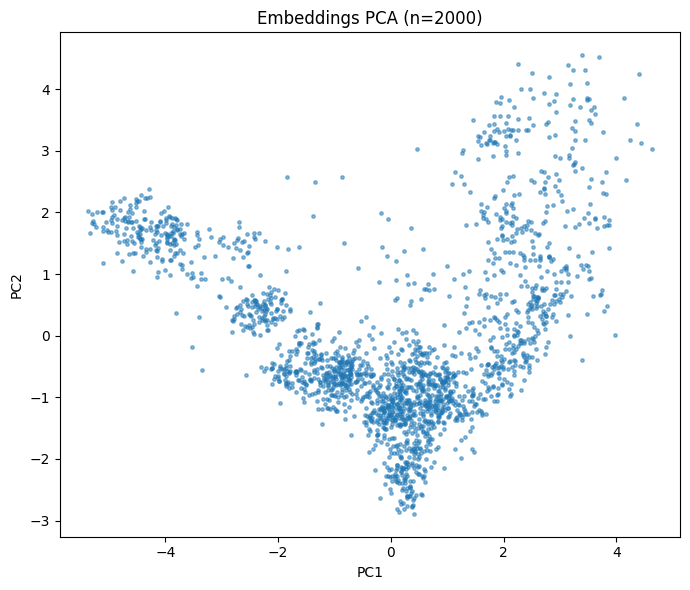

In [5]:
import matplotlib.pyplot as plt

# PCA (via SVD) to 2D for quick visualization (no sklearn dependency)
X = df_emb[[f"embedding_{i}" for i in range(128)]].to_numpy(dtype=np.float32)
X = X - X.mean(axis=0, keepdims=True)
U, S, Vt = np.linalg.svd(X, full_matrices=False)
pc2 = U[:, :2] * S[:2]

plt.figure(figsize=(7, 6))
plt.scatter(pc2[:, 0], pc2[:, 1], s=6, alpha=0.5)
plt.title(f"Embeddings PCA (n={len(df_emb)})")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()